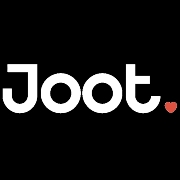

# Joot Code Challenge

*note: you will have to restart this code once for it to work properly. (Updating XGBoost package)*

## Short Description
Troubleshoot Machine Learning pipeline in Python. Demonstrate what might be causing low predicitions in model

## Requirements

This is a mid-level statistics task, using python. Ideal candidate will have some exposure to Machine Learning. 

The ideal candidate will have a degree (or pursuing degree) in one fo the following Statistics, Mathematics, Computer Science or something adjacent. 

Experience with the following Python packages:
* pandas
* numpy
* xgboost
* json
* boto3 (nice to have) 
* sagemaker(nice to have) 

## About Joot
Joot is a company that builds predictive models for Instagram, specifically a model that helps the user select the most engaging instagram images. 

By analyzing the engagement levels of past instagram post, extracting metadata, and performing feature generation using Computer Vision; Joot is able to generate models for businesses so they can always post the best image on their company social media pages. 

## The Challenge
The following is a coding challenge using real world data, where you are tasked with dianosing what is going wrong with the predictive  processes, and figure out why the model is returning bad outputs. 

You will be comparing the input dataset to the predictive dataset, and see if there are significant differences in any of the columns. There are generally around 4000 columns, but every column has a prefix and there are only a handful of prefixes, if something is going wrong it is probably happening at the prefix level and affecting all of the columns in that prefix (although that isn't guaranteed)

You will likely find the most success comparing and contrasting the data from the training set to the data from the predictive set, and seeing if there is any data that is **sparse** or **minimal variance** in one of the datasets, **but not both**. 

I will provide some EDA input below representing how I would begin to approach the project. 

## The Use Case





Loyal Stricklin is a Joot client and a leather goods retail company based in Nashville, Tennessee

They have input into the Joot interface that they would like to build an image model based on a conglamarate of the following accounts.
 
*   loyal_stricklin (their own account)
*   tannergoods
*   missionworkshop
*   trakkebags
*   treesizeverse
*   vermilyeapelle
*   bradleymountain

These accounts are also leather goods retailers/influencers. 



## Use Case Pipeline
(see diagram below)



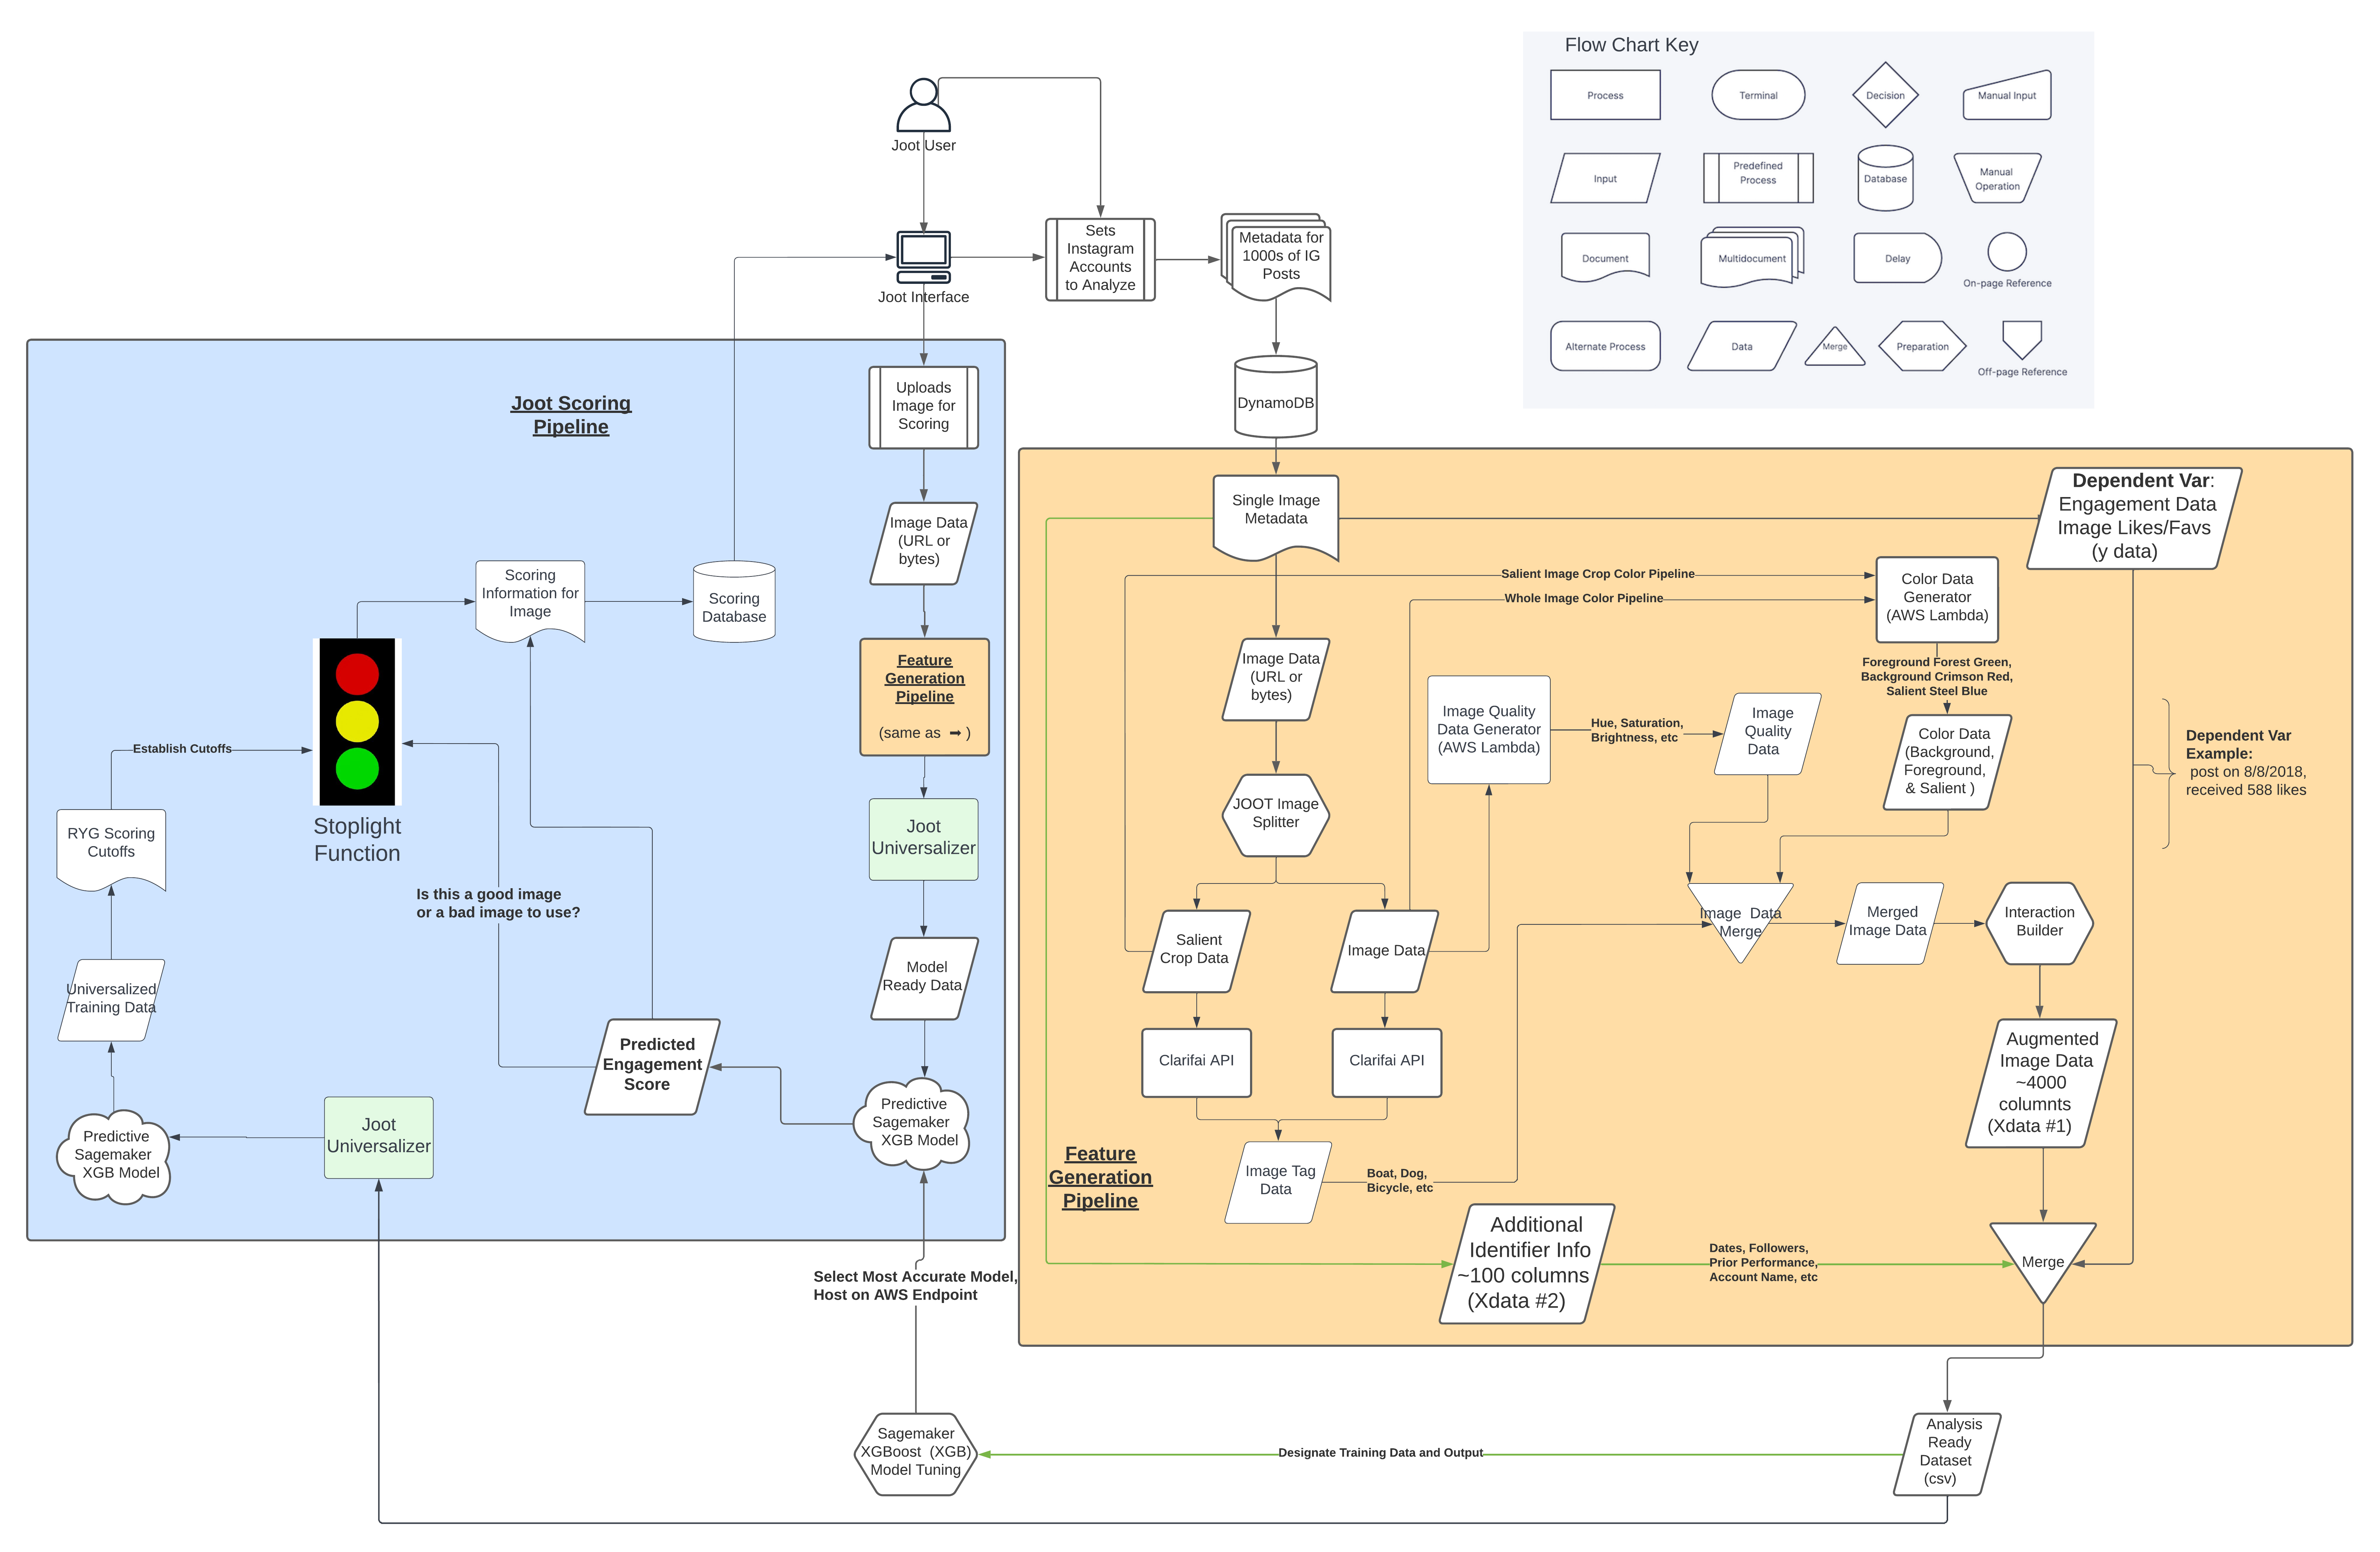

## The Universalizer

You may be wondering how our model controls for elements that are positively correlated with success, but not related to the content of the image. Elements such as the time of day when something is posted, or the posting of seasonal content (Halloween posts in October) are very integral to success on Instagram, but success in this arena does not tell us much about the power of the image. 

The Joot Universalizer controls for this. 

The Universalizer is a vital aspect of this project and company at large. The Universalizer takes all of the metadata information (which is generally expressed as binary variables in the training dataset, and converts it so that the metadata matrix reflects all of the same inputs. This only applies to metadata and not image data. This allows for the comparison of apples to apples across image.

Universalizer Impacts the Following Data:
*   Date Data (_d & _D)
*   Lags Data (LG_)
*   User Data (U_)

It does not affect:
*   Image Tag Data (WI_ & ST_)
*   Color Data (BG_, FG_, SAL_)
*   Image Quality Data (IQ_)

As you can observe in the diagram the Universalizer comes into play twice in the diagram.

Once, where all of the data in the training set has it's Metadata set to the same values and scored through the model. This is to establish ranges of values for our stoplight model. Typically a bottom.

There are two applications of the universalizer function, one for batch data and one for individual images (rows). The output on a per-row basis **should** be exactly the same, as they pass through the same function. 

The `handle` variable in the universalizer function is set to the account of the user running the analysis. For this analysis it will be `loyal_striklin`

##Stoplight Function

The stoplight function is  a way of assigning a categorical perfomance value to each image that is scored, for display on the front end. It is established entirely based on quantiles from when the training data is scored using the `Universalizer`  transformer. 


## The Data
See: "Data Column Info.txt"  in the CodeChallengeJootData folder

## Datasets Description

(Rank ordered roughly by importance)



1.   **train_data.csv**

The data that is used to build the sagemaker model. These are the images that have already been posted across the 7 accounts that have been designated. 


2.   **Folder:** Loyal_Stricklin_Market_Image_Score_Training_Sets

The data from new images after being scored, featuring the inputs and outputs. This is combined into a single dataframe below 

3. **model.tar.gz**

tar.gz file for the XGBoost model that is used for scoring inputs. Needs to be unzipped using gzip and then loaded via the pickle package (make sure Xgboost package is version 1.2.1).

The unzipping process code is done for you in the coding section of the colab file 

4. **Data Column Info.txt**

Contains information about what the different prefixes stand for in the dataset.


### Less important datasets, but useful for context
A) **loyal_stricklin_model_record.csv**

Metadata information about the sagemaker model. 

The only important thing here is that the "columns" column of the data contains the order in which the columns are expected during scoring. However, that order should already be reflected in the data as it stands 

B) **loyal_stricklin_market_scores.csv**

Contextual data that is the combination of the score column from #2 and the stoplight function, this is what the data looks like on the backend. 

There is a difference between this file and the score column in #2, because the #2 data was scored a few days later 

Unfortunately there is no mapping to the index from #2

C) **loyal_stricklin_market_all_accouts_batch_score_results.csv**

Un-universalized Scoring results for all posts from all accounts. 


D) **loyal_striicklini_market_images.json**

The data before it is converted into a matrix to create a predictive model for the uploaded images.


E) **Account JSONS**

-- treesizeverse.json

-- missionworkshop.json

-- bradleymountain.json

-- tannergoods.json

-- trakkebags.json

-- loyalstricklin.json

-- vermilyeapelle.json

Raw data before it is converted into a matrix to create a predictive model for the analyzed instagram posts. (Separated by IG account)

E is fundamentally the same data as D, except it is the raw image data + metadata used as inputs into the model vs. the unseen image data which is scored by the model. 






# CODE

## Universalizer Function

In [31]:

def universalizer(xdata , #training data to send to sagemaker
                handle, #account handle
                lags = True, #whether to include lagged variables
                month = False, #false if use current month, true replace value with specific month (1-12)
                year = False, #false if use current year, true replace value with specifid months
                pass_through_mean_likes  = False, #if false use median value of dataset, else use passedthrough data
                pass_through_mean_comments = False, #if false use median value of dataset, else use passedthrough data
                relative_date = False #False when dates are relative to January 1 2018, true if they are relative to the median of eachother.
                ):
    #standardizes data for easier comparison for apples to apples across accounts
    #UPDATE 3/11/21-- added month, year options, created better error handling
    #3/20/21 ---- made change so that dates are relative to a fixed point (1/1/2018)
    import pandas as pd
    from datetime import datetime as dt
    print("Universalizing for: {}".format(handle))

    ##NEW CODE TO CONTROL FOR DATASIZE DISCREPANCIES 1/8/2021
    columns_ = xdata.columns
    ###
    max_date_val = xdata['_dateR'].max()  #grabs max date value as universal date value
    Uhandle = 'U_'+ handle #puts handle information in the right Dataframe format
    #Delete if likes data is in the target dataset
    if 'post.like_count' in xdata:
        del xdata['post.like_count']
    if 'post.comments_count' in xdata:
        del xdata['post.comments_count']
    filter_U = [col for col in xdata if col.startswith('U_')] #select all user columns
    filter_D = [col for col in xdata if col.startswith('_D')] #select all date columns
    if lags:
        filter_LL = [col for col in xdata if col.startswith('LG_laggedLikes')]
        if pass_through_mean_likes != False:
            xdata[filter_LL] = pass_through_mean_likes
        else:#For universalizing data the lags data is set to the median value of all the posts in the datasets
            xdata[filter_LL] = xdata[filter_LL].apply(pd.to_numeric, args = ('coerce',))
            xdata[filter_LL] = xdata.groupby(Uhandle).median()['LG_laggedLikes_1'][1]

        filter_LC = [col for col in xdata if col.startswith('LG_laggedComments')]
        if pass_through_mean_comments != False:
            xdata[filter_LC] = pass_through_mean_comments
        else:
            xdata[filter_LC] = xdata[filter_LC].apply(pd.to_numeric, args = ('coerce',))
            xdata[filter_LC] = xdata.groupby(Uhandle).median()['LG_laggedComments_1'][1]
    year_now = '_Dy_'+str(dt.today().year) #isolate the column with year information
    month_now = '_Dm_' +str(dt.today().month) #isolate the column with month information
    #datedf['dateR']= pd.to_datetime(datedf['date'])
    #datedf['dateR']=datedf['dateR'].map(dt.datetime.toordinal)
    JanuaryFirst2018 = 736695
    day_now = dt.today().toordinal()- JanuaryFirst2018
    #hour_now = '_Dh_'+str(dt.today().month)
    #dow_now ='_Ddow_' +str( dt.today().weekday() )
    xdata[filter_U] = 0
    xdata[filter_D] = 0
    if year_now not in xdata:
        year_now = '_Dy_'+str(dt.today().year - 1)
    if year == False:
        xdata[year_now] = 1 #set year as this year
    else:
        year_str = '_Dy_' + str(year)
        xdata[year_str] = 1
    if month == False:
        xdata[month_now] = 1 #set month as this month
    else:
        month_str = '_Dm_' + str(month)
        xdata[month_str] = 1
    xdata['_Dh_8'] = 1 #set hour as 8AM
    #xdata[hour_now] = 1
    xdata['_Ddow_0'] = 1 #set day of week as Sunday
    #xdata[dow_now] = 1
    if Uhandle in xdata:
        xdata[Uhandle] = 1 #set all posts to user account
    else:
        xdata.loc[:, filter_U[0]] = 1 #set universalized value to the first competitor if there's no data for the handle
    if relative_date:
        xdata['_dateR'] = max_date_val #set all posts to highest date value
    else:
        xdata['_dateR'] = day_now
    ##NEW CODE TO CONTROL FOR DATASIZE DISCREPANCIES 1/8/2021
    if 'post.like_count' in columns_:
        columns_ = list(columns_)
        columns_.remove('post.like_count')
    xdata = xdata.loc[:, columns_]
    ####################
    return xdata

## Data Loading

Get the data out of the github repo

In [18]:
! git clone https://github.com/kenan-spruill/CodeChallengeJootData.git


Cloning into 'CodeChallengeJootData'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 146 (delta 105), reused 119 (delta 100), pack-reused 19
Receiving objects: 100% (146/146), 51.88 MiB | 19.99 MiB/s, done.
Resolving deltas: 100% (112/112), done.
Checking out files: 100% (119/119), done.


In [19]:
import xgboost as xgb

xgb_verz =xgb.__version__
print("XGB Version Must Be Equal to 1.2.1")
print("XGB Version: ", xgb_verz)

if xgb_verz != "1.2.1":
  print("INSTALLING CORRECT VERSION OF XGBOOST")
  print("You Will Need to Restart Runtime For Code Below to Work")
  !pip install xgboost==1.2.1
  raise

# importing the "tarfile" module
import tarfile
  
# open file
file = tarfile.open('/content/CodeChallengeJootData/ModelFiles/model.tar.gz')
  
# extracting file
file.extractall('/content/CodeChallengeJootData/ModelFiles')
  
file.close()

XGB Version Must Be Equal to 1.2.1
XGB Version:  1.2.1


In [20]:
import os
#change directory 
cwdir = os.getcwd()
if cwdir != "/content/CodeChallengeJootData":
  os.chdir("CodeChallengeJootData")
  
print("Here We Can See The Files in our Repo")

dir_files = os.listdir()

f_temp = []

print()
print("CSVs")
csvfis = []
for fi in dir_files:
  if fi[-4:] == ".csv":
    print("--",fi)
    f_temp.append(fi)
    csvfis.append(fi)

print()
jsonfis = []
print("JSONs")
for fi in dir_files:
  if fi[-5:] == ".json":
    print("--",fi)
    f_temp.append(fi)
    jsonfis.append(fi)

print()
print("Other Files")
for fi in dir_files:
  if fi not in f_temp:
    print("--",fi)



Here We Can See The Files in our Repo

CSVs
-- loyal_stricklin_market_all_accouts_batch_score_results.csv
-- loyal_stricklin_market_scores.csv
-- train_data.csv

JSONs
-- loyal_striicklini_market_images.json

Other Files
-- README.md
-- CodeChallengeJootData
-- .git
-- .DS_Store
-- universalizer.py
-- .gitattributes
-- AccountJsons
-- Loyal_Stricklin_Market_Image_Score_Training_Sets
-- Data Column Info.txt
-- ModelFiles


## Exploratory Data Analysis

In [21]:
#load training data
import pandas as pd
#create dictionary to hold our predictive data 
predict_dict = {
                "insta_img": {}, #training dataset (original instagram immages)
                "upload_img": {} #uploads dataset
                }

train_data_loc = "train_data.csv"
train_data = pd.read_csv(train_data_loc)

predict_dict["insta_img"]["X"] = train_data.drop("target", axis = 1)
predict_dict["insta_img"]["y"] = train_data.loc[:,"target"]

display(train_data)

,target,U_bradleymountain,_dateR,_Dy_2014,_Dy_2015,_Dy_2016,_Dy_2017,_Dy_2022,_Dm_1,_Dm_2,...,SAL_hotpink,SAL_razzle_dazzle_rose,SAL_commonyellow,BG_royalblue,BG_blue_ryb,BG_slateblue,BG_aquamarine,FG_brightgreen,FG_puregold,FG_tea_green
0,1986.0,1.0,-977,0.0,1.0,0.0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,738.0,0.0,-727,0.0,0.0,1.0,0.0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.0,0.0,-1853,0.0,0.0,0.0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,705.0,0.0,-1050,0.0,1.0,0.0,0.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,65.0,0.0,-412,0.0,0.0,1.0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5021,296.0,0.0,-740,0.0,1.0,0.0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5022,508.0,0.0,39,0.0,0.0,0.0,0.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5023,577.0,0.0,-931,0.0,1.0,0.0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5024,2654.0,1.0,-622,0.0,0.0,1.0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
import random
from pprint import pprint

#let's look at the shape of the data
print("Train Data Shape: ", train_data.shape)
#let's get a list of columns in the train data
train_cols = list(train_data.columns)
#let's look at 20 random columns
print("20 Random Columns")
pprint(random.sample(train_cols, 20))


Train Data Shape:  (5026, 3923)
20 Random Columns
['WI_sewing',
 'WI_blanc',
 'WI_sunglasses',
 'WI_tumbler',
 'WI_breakfast',
 'WI_rue',
 'WI_Buddha',
 'WI_bamboo',
 'WI_agent',
 'WI_hard',
 'WI_luggage',
 'WI_worthless',
 'WI_library',
 'WI_minute_hand',
 'WI_meat',
 'WI_first_aid',
 'WI_set_up',
 'FG_tyrian_purple',
 'WI_cruiser',
 'BG__L_CaputMortuum']


In [23]:
#let's get a list of the common prefixes
prefixes = []
prefix_dict = {}
for k in train_cols:
  add_val = k.split("_")
  if add_val[0] == "":
    append_val = "_" + add_val[1]
  else:
    append_val = add_val[0]
  if append_val not in prefix_dict:
    prefix_dict[append_val] = []
  
  prefix_dict[append_val].append(k)
  if append_val not in prefixes:
    prefixes.append(append_val)

pprint(prefixes)
pprint(prefix_dict.keys())



['target',
 'U',
 '_dateR',
 '_Dy',
 '_Dm',
 '_Ddow',
 '_Dh',
 'IQ',
 'WI',
 'SAL',
 'BG',
 'FG',
 'LG']
dict_keys(['target', 'U', '_dateR', '_Dy', '_Dm', '_Ddow', '_Dh', 'IQ', 'WI', 'SAL', 'BG', 'FG', 'LG'])


In [24]:
#let's look at the breakdowns for our columns

for prefix in prefix_dict:
  print()
  print("################")
  print("Prefix: ", prefix)
  d_val = prefix_dict[prefix]
  prefix_len = len(d_val)
  print("--Prefix Members: ", prefix_len)
  if prefix_len < 25: 
    print()
    print("--Values")
    pprint(d_val)
  


################
Prefix:  target
--Prefix Members:  1

--Values
['target']

################
Prefix:  U
--Prefix Members:  7

--Values
['U_bradleymountain',
 'U_loyalstricklin',
 'U_missionworkshop',
 'U_tannergoods',
 'U_trakkebags',
 'U_treesizeverse',
 'U_vermilyeapelle']

################
Prefix:  _dateR
--Prefix Members:  1

--Values
['_dateR']

################
Prefix:  _Dy
--Prefix Members:  11

--Values
['_Dy_2014',
 '_Dy_2015',
 '_Dy_2016',
 '_Dy_2017',
 '_Dy_2022',
 '_Dy_2012',
 '_Dy_2013',
 '_Dy_2021',
 '_Dy_2018',
 '_Dy_2019',
 '_Dy_2020']

################
Prefix:  _Dm
--Prefix Members:  12

--Values
['_Dm_1',
 '_Dm_2',
 '_Dm_3',
 '_Dm_4',
 '_Dm_5',
 '_Dm_6',
 '_Dm_7',
 '_Dm_8',
 '_Dm_9',
 '_Dm_10',
 '_Dm_11',
 '_Dm_12']

################
Prefix:  _Ddow
--Prefix Members:  7

--Values
['_Ddow_0', '_Ddow_1', '_Ddow_2', '_Ddow_3', '_Ddow_4', '_Ddow_5', '_Ddow_6']

################
Prefix:  _Dh
--Prefix Members:  24

--Values
['_Dh_0',
 '_Dh_1',
 '_Dh_2',
 '_Dh_3',
 '_Dh_4',


In [25]:
#code from https://www.geeksforgeeks.org/how-to-read-all-csv-files-in-a-folder-in-pandas/
#getting code for folder
# import necessary libraries
import pandas as pd
import os
import glob
  
  
# use glob to get all the csv files 
# in the folder
path = "/content/CodeChallengeJootData/Loyal_Stricklin_Market_Image_Score_Training_Sets" #os.getcwd()
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
new_images_df = pd.DataFrame()
# loop over the list of csv files
print("Combine CSVs in the Following Folder: {}".format(path))
for f in csv_files:
      
    # read the csv file
    temp_df = pd.read_csv(f, index_col = 0)
      
    # print the location and filename
    #print('Location:', f)
    #print('File Name:', f.split("\\")[-1])
    new_images_df = pd.concat([new_images_df, temp_df])

#moving the last column "score" to the front of the dataframe to match the test dataframe
cols = ["score"] + list(new_images_df.columns)[:-1]
new_images_df= new_images_df[cols]



predict_dict["upload_img"]["y"] = y_new_images = new_images_df["score"]

predict_dict["upload_img"]["X"] = X_new_images = new_images_df.drop(["score"], axis = 1) 


display(new_images_df.sort_values("score"))

Combine CSVs in the Following Folder: /content/CodeChallengeJootData/Loyal_Stricklin_Market_Image_Score_Training_Sets


,score,U_bradleymountain,_dateR,_Dy_2014,_Dy_2015,_Dy_2016,_Dy_2017,_Dy_2022,_Dm_1,_Dm_2,...,SAL_hotpink,SAL_razzle_dazzle_rose,SAL_commonyellow,BG_royalblue,BG_blue_ryb,BG_slateblue,BG_aquamarine,FG_brightgreen,FG_puregold,FG_tea_green
35b4ea8d-e8ee-430c-9634-c8357d87f3e2,-21.795092,0,1688,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
e974dfc6-f7a0-4c93-9e02-07ea91e52e6d,0.313737,0,1688,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6417d08c-36b7-4fb7-9004-c1af4b8617d0,0.567045,0,1688,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4ada2470-8c31-4a44-bb8f-2d636db53257,2.285691,0,1688,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2dcff3c7-ba22-4a3c-94f6-2ba4d15474c5,3.151964,0,1688,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0e7b0bfd-057f-4f15-8e9a-d6e4d9e88ad8,43.833382,0,1688,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
73714e0b-243b-4351-a809-2636ec60c9fb,44.991684,0,1688,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4a1dee22-196c-4220-8964-e286f484a409,55.772102,0,1688,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
b5ee9925-8bca-415c-8212-52a457a18b04,58.287964,0,1688,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Previewing Other Datasets

In [26]:
import json

acct_jsons = ['treesizeverse.json',
 'missionworkshop.json',
 'bradleymountain.json',
 'tannergoods.json',
 'trakkebags.json',
 'loyalstricklin.json',
 'vermilyeapelle.json']

pathx = "/content/CodeChallengeJootData/loyal_stricklin_market_scores.csv"
pathy = "/content/CodeChallengeJootData/loyal_stricklin_market_all_accouts_batch_score_results.csv"
pathz = "/content/CodeChallengeJootData/ModelFiles/loyal_stricklin_model_record.csv"
pathJa = "/content/CodeChallengeJootData/loyal_striicklini_market_images.json"
pathJb = "/content/CodeChallengeJootData/AccountJsons/{}"

market_scores = pd.read_csv(pathx)
market_all_account_batch_score_results = pd.read_csv(pathy)
model_record = pd.read_csv(pathz)

print("Data: ")
print(pathx.split("/")[-1])
#sort by score to see mapping to the new_df
display(market_scores.sort_values("score").head())

print()
print("Data: ")
print(pathy.split("/")[-1])
display(market_all_account_batch_score_results.sort_values("sk").head())
print("Score Means By Account")
display(market_all_account_batch_score_results.groupby("pk").mean()["score"])




print()
print("Data: ")
print(pathJa.split("/")[-1])
print()
print("--Converting to Flattened DataFrame")
# Opening JSON file
with open(pathJa) as json_file:
    market_images_J = json.load(json_file)
market_images_df = pd.json_normalize(market_images_J)
display(market_images_df.head())


temp_acc = 'loyalstricklin.json'
pathJb = pathJb.format(temp_acc)
print()
print("Data: ")
print(pathJb.split("/")[-1])
print()
print("--Note: Data is Representative of All Jsons:")
pprint(acct_jsons)
print("--Converting to Flattened DataFrame")

with open(pathJb.format(temp_acc)) as json_file:
    acc_J = json.load(json_file)

acc_df = pd.json_normalize(acc_J)
display(acc_df.head())


Data: 
loyal_stricklin_market_scores.csv


,created_at,pk2,score,sk,sk2,quantile,pk,type
15,2022-03-09T21:34:38,#score#A#admin@stryde.com,-23.591684,M#Loyal Stricklin#1646676444757#Loyal Stricklin,M#Loyal Stricklin,RED,#score#A#admin@stryde.com,score
93,2022-03-09T21:34:43,#score#A#admin@stryde.com,-0.420631,M#Loyal Stricklin#1646861581702#Loyal Stricklin,M#Loyal Stricklin,RED,#score#A#admin@stryde.com,score
80,2022-03-09T21:34:37,#score#A#admin@stryde.com,0.345032,M#Loyal Stricklin#1646682204268#Loyal Stricklin,M#Loyal Stricklin,RED,#score#A#admin@stryde.com,score
91,2022-03-09T21:35:01,#score#A#admin@stryde.com,2.486208,M#Loyal Stricklin#1646861494790#Loyal Stricklin,M#Loyal Stricklin,RED,#score#A#admin@stryde.com,score
13,2022-03-09T21:34:32,#score#A#admin@stryde.com,3.677726,M#Loyal Stricklin#1646676442807#Loyal Stricklin,M#Loyal Stricklin,RED,#score#A#admin@stryde.com,score



Data: 
loyal_stricklin_market_all_accouts_batch_score_results.csv


,created_at,pk2,sk,score,sk2,pk,type
357,2022-03-05T01:50:17,#score#missionworkshop,P#2012-02-26T00:15:00+0000#17842193089061204#a...,16.646584,admin@stryde.com#Loyal Stricklin,#score#missionworkshop,score
222,2022-03-05T01:50:17,#score#missionworkshop,P#2012-02-29T18:12:45+0000#17842609540061204#a...,8.901231,admin@stryde.com#Loyal Stricklin,#score#missionworkshop,score
351,2022-03-05T01:50:17,#score#missionworkshop,P#2012-03-03T17:11:51+0000#17842609828061204#a...,16.346935,admin@stryde.com#Loyal Stricklin,#score#missionworkshop,score
587,2022-03-05T01:50:17,#score#missionworkshop,P#2012-03-05T16:35:10+0000#17841975097061204#a...,32.232887,admin@stryde.com#Loyal Stricklin,#score#missionworkshop,score
502,2022-03-05T01:50:17,#score#missionworkshop,P#2012-03-06T21:17:48+0000#17842610140061204#a...,25.956377,admin@stryde.com#Loyal Stricklin,#score#missionworkshop,score


Score Means By Account


pk
#score#bradleymountain    2201.967712
#score#loyalstricklin      327.389703
#score#missionworkshop     145.029882
#score#tannergoods         416.146477
#score#trakkebags           37.175391
#score#treesizeverse        62.597779
#score#vermilyeapelle      215.918585
Name: score, dtype: float64


Data: 
loyal_striicklini_market_images.json

--Converting to Flattened DataFrame


,status,account_name,starred,sk,image_library,created_at,ai_detected_tags,processing_status,item_type,updated_at,...,image_color_background.color_names.darksalmon.perc_image,image_color_background.color_names.wheat.perc_image,image_color_background.color_names._M_MidOrange.perc_image,image_color_foreground.color_names._M_DarkOrange.perc_image,image_color_foreground.color_names._H_Orange.perc_image,image_color_foreground.color_names.peru.perc_image,image_color_background.color_names.darkslategray.perc_image,image_color_background.color_names._M_Teal.perc_image,image_color_background.color_names.cadetblue.perc_image,image_color_background.color_names.ucla_blue.perc_image
0,new,admin@stryde.com,False,M#Loyal Stricklin#1646676422208,Loyal Stricklin,2022-03-07T18:07:05,"[leather, luggage, portfolio, case, bag, purse...",V1,image,2022-07-28T19:51:56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,new,admin@stryde.com,False,M#Loyal Stricklin#1646676430033,Loyal Stricklin,2022-03-07T18:07:12,"[leather, wear, luggage, fashion, purse, bag, ...",V1,image,2022-07-28T19:51:56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,new,admin@stryde.com,False,M#Loyal Stricklin#1646676431283,Loyal Stricklin,2022-03-07T18:07:13,"[portrait, leather, people, man, fashion, one,...",V1,image,2022-07-28T19:51:56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,new,admin@stryde.com,False,M#Loyal Stricklin#1646676433088,Loyal Stricklin,2022-03-07T18:07:15,"[fashion, leather, bag, purse, glamour, woman,...",V1,image,2022-07-28T19:51:56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,new,admin@stryde.com,False,M#Loyal Stricklin#1646676433814,Loyal Stricklin,2022-03-07T18:07:16,"[outdoors, people, man, woman, one, hand, natu...",V1,image,2022-07-28T19:51:56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Data: 
loyalstricklin.json

--Note: Data is Representative of All Jsons:
['treesizeverse.json',
 'missionworkshop.json',
 'bradleymountain.json',
 'tannergoods.json',
 'trakkebags.json',
 'loyalstricklin.json',
 'vermilyeapelle.json']
--Converting to Flattened DataFrame


,ai_detected_tags,processing_status,item_type,updated_at,sk,pk,image_cache.s3.bucket,image_cache.s3.url_150,image_cache.s3.url_800,image_cache.s3.url_400,...,image_color_background.color_names.dark_green.perc_image,image_color_salient_object.color_names.salmon.perc_image,image_color_foreground.color_names.lightcoral.perc_image,image_color_salient_object.color_names.boysenberry.perc_image,image_color_salient_object.color_names.darkseagreen.perc_image,image_color_salient_object.color_names.cobalt.perc_image,image_color_salient_object.color_names.dark_green.perc_image,image_color_background.color_names.blue_pigment.perc_image,image_color_foreground.color_names._M_MidYellow.perc_image,image_color_foreground.color_names.khaki.perc_image
0,"[step, architecture, bridge, city, window, mod...",V1,post,2022-03-04T16:56:58,P#2012-10-11T20:09:02+0000#17842371442052083,loyalstricklin,joot-api-resources-prod-instagramimagesbucket-...,http://joot-api-resources-prod-instagramimages...,http://joot-api-resources-prod-instagramimages...,http://joot-api-resources-prod-instagramimages...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[desktop, abstract, retro, texture, design, ar...",V1,post,2022-03-04T16:56:25,P#2012-10-11T20:09:31+0000#17842371448052083,loyalstricklin,joot-api-resources-prod-instagramimagesbucket-...,http://joot-api-resources-prod-instagramimages...,http://joot-api-resources-prod-instagramimages...,http://joot-api-resources-prod-instagramimages...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[sunset, sun, landscape, dawn, sky, light, sil...",V1,post,2022-03-04T16:56:42,P#2012-10-11T22:51:59+0000#17842371472052083,loyalstricklin,joot-api-resources-prod-instagramimagesbucket-...,http://joot-api-resources-prod-instagramimages...,http://joot-api-resources-prod-instagramimages...,http://joot-api-resources-prod-instagramimages...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[desktop, illustration, vector, design, equipm...",V1,post,2022-03-04T16:56:06,P#2012-10-12T15:11:12+0000#17842371589052083,loyalstricklin,joot-api-resources-prod-instagramimagesbucket-...,http://joot-api-resources-prod-instagramimages...,http://joot-api-resources-prod-instagramimages...,http://joot-api-resources-prod-instagramimages...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[plaid, blanket, square, wear, portrait, peopl...",V1,post,2022-03-04T16:56:39,P#2012-10-13T23:01:49+0000#17842371961052083,loyalstricklin,joot-api-resources-prod-instagramimagesbucket-...,http://joot-api-resources-prod-instagramimages...,http://joot-api-resources-prod-instagramimages...,http://joot-api-resources-prod-instagramimages...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Using The Tar.Gz file to create a model

In [27]:
from pprint import pprint
print("Check Model Information")
print()
print("Data: ")
print(pathz.split("/")[-1])
print()
pprint(model_record.iloc[0])

Check Model Information

Data: 
loyal_stricklin_model_record.csv

columns               ["target","U_bradleymountain","_dateR","_Dy_20...
mme_model_name        admin-strxgb-tuning-04-22-33-42-026-18d7ae7d.t...
created_at                                          2022-03-04T22:30:22
sagemaker_job_name                      admin-strxgb-tuning-04-22-33-42
status                                                        completed
mme_endpoint_name                                        mme-xgboost003
account_name                                           admin@stryde.com
updated_at                                          2022-03-05T01:43:48
pk2                                                              #model
targetY                                                 post.like_count
sk                    admin@stryde.com#Loyal  Stricklin#2022-03-04T2...
sk2                                     admin-strxgb-tuning-04-22-33-42
pk                                                               #mode

In [28]:
#model load 
##REMEMBER YOU NEED TO UPDATE THE XGBOOST PACKAGE FOR THIS TO WORK THIS IS DONE AT THE BEGINNING OF THE CODING SECTION
from pprint import pprint
import pickle
print()
print("LOADING MODEL FROM tar.gz FILE")
model_path2 = "/content/CodeChallengeJootData/ModelFiles/xgboost-model"
xgb_model = pickle.loads(open(model_path2, "rb").read())
print()
print("--MODEL TYPE: ", type(xgb_model))
print()
print("--Model Requires {} Features/Columns".format(len(xgb_model.feature_names)))
print()
print("--XGB Model Directory:")
print()
pprint(dir(xgb_model))




LOADING MODEL FROM tar.gz FILE
[23:55:21] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.

--MODEL TYPE:  <class 'xgboost.core.Booster'>

--Model Requires 3922 Features/Columns

--XGB Model Directory:

['__class__',
 '__copy__',
 '__deepcopy__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_validate_features',
 'attr',
 'attributes',
 'best_iteration',
 'best_ntree_limit',
 'boost',
 'booster',
 'copy',
 'dump_model',
 'eval',
 'eval_set',
 'feature_names',
 'feature_types',
 'get_dump',
 'get_fscore',
 'get_score',
 'get_split_value_histogram',
 'handle',
 'inplace_predict

In [29]:
print("Using model to verify results on preexising predictions")
print()

predict_keys = ["upload_img", "insta_img"] #predict_dict.keys()
key = "upload_img"

X = predict_dict[key]["X"].values
y = predict_dict[key]["y"].values
X = xgb.DMatrix(X) #have to convert to Dmatrix for xgb_model to work 

#adding values to dictionary 
predict_dict[key]["y_pred"] = y_pred = xgb_model.predict(X)

print("First 5 Image Upload Predictions")
display(y_pred[0:5])

print()
print("First 5 Image Upload Predictions From Database")
display(y[0:5])

print()
print("They are the same!")

##YOU MAY WANT TO PLAY AROUND WITH THIS ON THE TRAINING DATASET AS WELL IN CORROBORATION WITH THE UNIVERSALIER

Using model to verify results on preexising predictions

First 5 Image Upload Predictions


array([26.252426,  8.528251, 11.599193, 80.98867 , 23.692453],
      dtype=float32)


First 5 Image Upload Predictions From Database


array([26.25242615,  8.52825069, 11.59919262, 80.98867035, 23.69245338])


They are the same!


## Combining Universalizing + Scoring

In [33]:
handle = "loyalstricklin"
for key in predict_dict:
  ##UNIVERSALIZING
  predict_dict[key]["X_uni"] = X_uni = universalizer(xdata = predict_dict[key]["X"], 
                handle = handle)
  
  ##SCORING
  X = xgb.DMatrix(X_uni.values) #have to convert to Dmatrix for xgb_model to work 
  predict_dict[key]["y_pred_uni"] = y_pred = xgb_model.predict(X)



Universalizing for: loyalstricklin
Universalizing for: loyalstricklin


# Your Turn

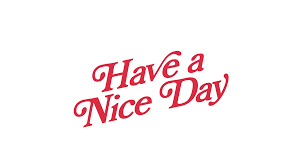